In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import matplotlib.pylab as pl
from pykalman import KalmanFilter
from statsmodels.tsa.api import VAR
from numpy.linalg import inv,det
%run functions.ipynb

In [7]:
X,Gamma,F=generate_test_data(100,1000)

In [8]:
loading,factor=calculate_pca(X,5)

r2= 0.8585077507954922
r2= 0.8644680786082981
r2= 0.92055917656565
r2= 0.9865707290862469
r2= 0.910933768832469


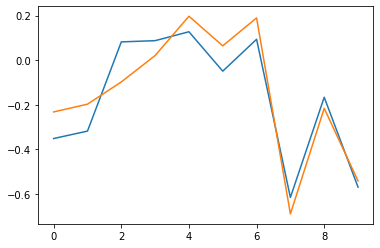

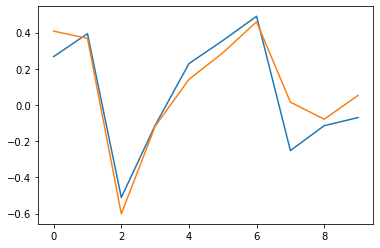

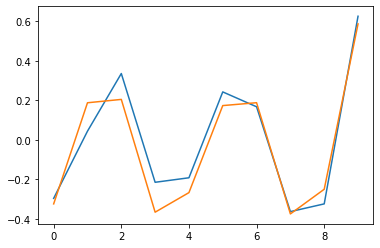

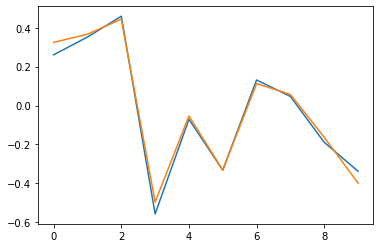

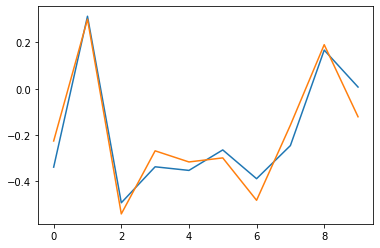

In [4]:
compare_loading_plot(Gamma,loading)

r2= 0.8329969785523359
r2= 0.7719086633221184
r2= 0.7624713670647787
r2= 0.7849086701476846
r2= 0.6025694205023551


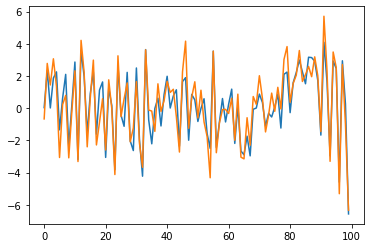

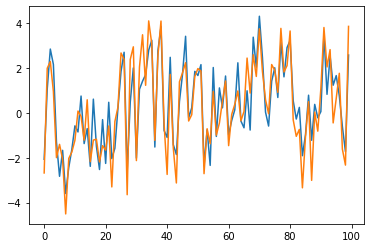

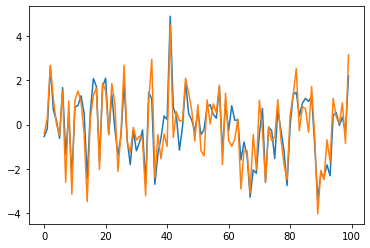

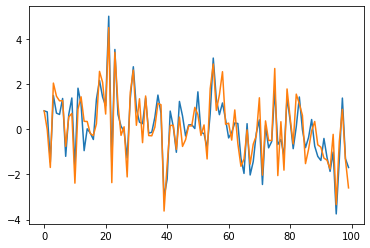

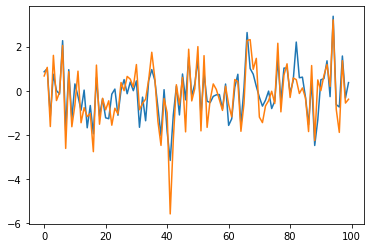

In [18]:
compare_factor_plot(F,factor)

In [29]:
#model factors as VAR 

model = VAR(factor.T)
results = model.fit(maxlags=5, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Jul, 2020
Time:                     14:01:17
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    3.54006
Nobs:                     997.000    HQIC:                   3.29611
Log likelihood:          -8561.94    FPE:                    23.2549
AIC:                      3.14650    Det(Omega_mle):         21.4755
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.091745         0.041353           -2.219           0.027
L1.y1         0.000072         0.015233            0.005           0.996
L1.y2         0.001093         0.018100            0.060           0.952
L1.y3         0.057414

In [30]:
VAR_param=results.coefs
VAR_resid=results.resid

In [31]:
VAR_param.shape
VAR_resid.shape

(997, 5)

In [9]:
def to_state_space_rep(loading,factor,lag,obs_res_cov,factor_res_cov):
    n_factor=len(factor)
    #put factors and their lags into one vector
    stacked_factor=np.array([np.roll(factor,i,axis=1)[:,(lag-1):] for i in range(lag)])
    stacked_factor=stacked_factor.reshape(lag*n_factor,-1)
    #estimate dynamics of factors using VAR(1)
    model = VAR(stacked_factor.T)
    results = model.fit(1)
    stacked_var_param=results.coefs[0]
    # constrcut loading of state space model (\Lambda 0 0)
    stacked_loading=np.concatenate((loading,np.zeros((loading.shape[0],loading.shape[1]*(lag-1)))),axis=1)
    # construct residue matrix G
    G=np.concatenate((np.eye(n_factor),np.zeros((n_factor*(lag-1),n_factor))),axis=0)
    # construct covariance matrix for stacked factor residues
    stacked_factor_res_cov=G@factor_res_cov@(G.T)
    return State_Space_Wrapper(stacked_loading,stacked_factor,stacked_var_param,obs_res_cov,stacked_factor_res_cov)
class State_Space_Wrapper():
    def __init__(self, stacked_loading,stacked_factor,stacked_var_param,obs_res_cov,stacked_factor_res_cov):
        self.stacked_factor = stacked_factor
        self.stacked_loading = stacked_loading
        self.stacked_var_param = stacked_var_param  
        self.obs_res_cov=obs_res_cov
        self.stacked_factor_res_cov=stacked_factor_res_cov
def stacked_F(F,lag):
    n_factor=len(F)
    stacked_factor=np.array([np.roll(F,i,axis=1)[:,(lag-1):] for i in range(lag)])
    stacked_factor=stacked_factor.reshape(lag*n_factor,-1)
    return stacked_factor

In [10]:
m1=to_state_space_rep(loading,factor,3,np.cov(X),np.eye(5))
true_model=to_state_space_rep(Gamma,F,3,np.cov(X),np.eye(5))

In [11]:
def pairwise_covariance(smoothed_state_covariances,kalman_smoothing_gain):
    """
    Calculate covariance between hidden states at `t` and `t-1` for
    all time step pairs
    
    Parameters
    ----------
    smoothed_state_covariances : [n_timesteps, n_dim_state, n_dim_state] array
        covariance of hidden state given all observations
    kalman_smoothing_gain : [n_timesteps-1, n_dim_state, n_dim_state]
        Correction matrices from Kalman Smoothing
    Returns
    -------
    pairwise_covariances : [n_timesteps, n_dim_state, n_dim_state] array
        Covariance between hidden states at times t and t-1 for t =
        [1...n_timesteps-1].  Time 0 is ignored.
    """

    n_timesteps, n_dim_state, _ = smoothed_state_covariances.shape
    pairwise_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))
    for t in range(1, n_timesteps):
        pairwise_covariances[t] = (
            np.dot(smoothed_state_covariances[t],
                   kalman_smoothing_gain[t - 1].T)
        )
    return pairwise_covariances

In [12]:
def e_step(state_space_wrapper,observations):
    
    # initialize parameters
    transition_matrix = state_space_wrapper.stacked_var_param
    observation_matrix = state_space_wrapper.stacked_loading
    transition_covariance = state_space_wrapper.stacked_factor_res_cov
    observation_covariance = state_space_wrapper.obs_res_cov
    #initial_state_mean = [5, -5]
    #initial_state_covariance = [[1, 0.1], [-0.1, 1]]

    # e_step
    kf = KalmanFilter(
        transition_matrices=transition_matrix, observation_matrices=observation_matrix,transition_offsets=None
    ,observation_offsets=None
    ,observation_covariance=None,transition_covariance=transition_covariance)
    
    #change input format
    observations=observations.T
    
    # estimate state with filtering and smoothing
    smoothed_state_mean,smoothed_state_covariances,smoothing_gain = kf.smooth(observations)
    #print(smoothing_gain)
    # draw estimates
    '''S_F=stacked_F(F,3)
    r2=[]
    for i in range(15):
        pl.figure()
        lines_true = pl.plot([0,0]+list(S_F[i]), color='b')
        lines_filt = pl.plot(filtered_state_estimates[i], color='r')
        lines_smooth = pl.plot(smoothed_state_estimate[i], color='g')
        r2.append(r2_score(S_F[i],smoothed_state_estimate[i][2:]))
        pl.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
                  ('true', 'filt', 'smooth'),
                  loc='lower right'
        )
        pl.show()
    print(statistics.mean(r2))'''
    # estimated mean and covariances [n_factor,n_time_step], [n_time_step,n_factor,n_factor]
    return  smoothed_state_mean.T,smoothed_state_covariances,pairwise_covariance(smoothed_state_covariances,smoothing_gain)
    

In [21]:
a,b,c=e_step(m1,X)

In [22]:

def m_step(stacked_factor,stacked_factor_cov,pairwise_cov,observations):
    T=len(stacked_factor_cov)
    xF=observations@(stacked_factor.T)
    xx=observations@(observations.T)
    FF=stacked_factor@(stacked_factor.T)+stacked_factor_cov.sum(axis=0)
    #construct factor_{t-1}
    F_1=np.roll(stacked_factor,1,axis=1)
    F_1[:,0]=0
    FF_1=stacked_factor@(F_1.T)+pairwise_cov.sum(axis=0)
    F_1F_1=F_1@(F_1.T)+stacked_factor_cov[1:].sum(axis=0)
    #compute loading
    new_stacked_loading=xF@inv(FF)
    #compute dynamics matrix A
    new_var_param=FF_1@inv(F_1F_1)
    #compute obs_res_cov
    new_obs_res_cov=(xx-new_stacked_loading@(xF.T))/T
    #compute factor_res_cov
    new_factor_res_cov=(FF-new_var_param@(FF_1.T))/T
    
    return new_stacked_loading,new_var_param,new_obs_res_cov,new_factor_res_cov

In [23]:
a,b,c,d=m_step(a,b,c,X)
ss=State_Space_Wrapper(a,[],b,c,d)
new_f=e_step(ss,X)[0]

In [27]:
def loglikelyhood(stacked_factor, stacked_loading, var_param, obs_res_cov, factor_res_cov, observations):
    T=observations.shape[1]
    F_1=np.roll(stacked_factor,1,axis=1)
    F_1[:,0]=0
    F_deleted=stacked_factor
    F_deleted[:0]=0
    det1=det(obs_res_cov)
    det2=det(factor_res_cov)
    obs_term=observations-stacked_loading@stacked_factor
    factor_term=F_deleted-var_param@F_1
    trace1=np.trace((obs_term.T)@inv(obs_res_cov)@(obs_term))
    trace2=np.trace((factor_term.T)@inv(factor_res_cov)@(factor_term))
    
    return -0.5*(T*np.log(det1)+T*np.log(det2)+trace1+trace2)

In [28]:
loglikelyhood(new_f,a,b,c,d,X)

140540.96185240938

In [ ]:
 ll = sum([       np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])),
                                            (zt-dot(C,model.zsmooth[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
           
                          len(model.y)*np.log(norm(Sig_u)),
           
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)),
                                            (model.y[i]-dot(A,zt)).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])